In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

MAXIMUM_DT = 20.0

def transform_log_to_sequence_example(logfile, dimension):
    data_names = ['x'+str(i) for i in range(dimension-1)]
    column_names = ['date', 'source'] + data_names
    perf_df = pd.read_csv(logfile,
                          header=None, parse_dates=True,
                          index_col=0, names=column_names)
    #  Filter out RNN lines, just keep 'interface'
    if "rnnbox" in logfile:
        print("Old RNNbox file, dividing by 255")
        perf_df.x0 /= 255
    perf_df = perf_df[perf_df.source == 'interface']
    #  Process times.
    perf_df['t'] = perf_df.index
    perf_df.t = perf_df.t.diff()
    perf_df.t = perf_df.t.dt.total_seconds()
    perf_df = perf_df.dropna()
    perf_df.at[perf_df[perf_df.t > MAXIMUM_DT].index, 't'] = MAXIMUM_DT
    print(perf_df.describe())
    return np.array(perf_df[['t']+data_names])

def plot_nn_output(output_df, name="unknown", colour='b'):
    """Plot the data in output_df assuming it has columns x and time"""
    sns.set_style('whitegrid')
    sns.set_context('paper')
    f, ax = plt.subplots(figsize=(8, 2))
    sns.lineplot(x='time', y='x', data=perf_df, ax=ax, legend=False, color=colour)
    ax.set_xlabel("seconds")
    ax.set_ylabel("position")
    ax.set(ylim=(-0.1, 1.1))
    sns.despine(f, left=True, bottom=True)
    #ax = perf_df.plot(x='time', y='x', kind="line", color=colour, figsize=(8,2), legend=False)
    ax.get_figure().savefig('../images/model_output/'+name+'_model_output.pdf', dpi=300, bbox_inches="tight")
    ax.get_figure().savefig('../images/model_output/'+name+'_model_output.png', dpi=300, bbox_inches="tight")

In [14]:
logfile = "2019-09-23T01-52-53-2d-mdrnn.log"
perf_array = transform_log_to_sequence_example(logfile, 2)
column_names = ['date', 'source', 'x0']
perf_df = pd.read_csv(logfile,
                      header=None, parse_dates=True,
                      index_col=0, names=column_names)

                 x0             t
count  15474.000000  15474.000000
mean       0.475421      0.039115
std        0.260138      0.118139
min        0.007874      0.001581
25%        0.259843      0.027073
50%        0.480315      0.031946
75%        0.685039      0.032049
max        1.000000      4.244142


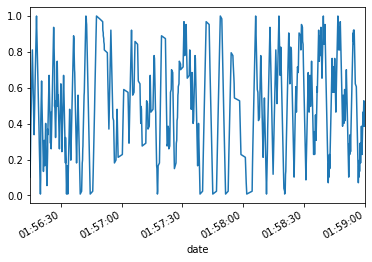

In [13]:
colour = sns.color_palette('deep')[2]

perf_df.x0[4000:8000].plot()

In [ ]:
# Load up the performances
log_location = "rnn_box_data/"
log_file_ending = ".log" #"-" + str(args.dimension) + "d-mdrnn.log"
log_arrays = []

for local_file in os.listdir(log_location):
    if local_file.endswith(log_file_ending):
        print("Processing:", local_file)
        try:
            log = transform_log_to_sequence_example(log_location + local_file,2)
            log_arrays.append(log)
        except Exception:
            print("Processing failed for", local_file)        

# Save Performance Data in a compressed numpy file.
dataset_location = 'datasets/'
dataset_filename = 'empi-human-dataset.npz'

# Input format is:
# 0. 1. 2. ... n.
# dt x1 x2 ... xn

raw_perfs = []
acc = 0
time = 0
interactions = 0
for l in log_arrays:
    acc += l.shape[0] * l.shape[1]
    interactions += l.shape[0]
    print("interactions:", l.shape[0])
    time += l.T[0].sum()
    try:
        max_time = l.T[0].max()
    except:
        max_time = 0
    print("max_time:", max_time)
    raw = l.astype('float32')  # dt, x_1, ... , x_n
    raw_perfs.append(raw)

print("total number of values:", acc)
print("total number of interactions:", interactions)
print("total time represented:", time)
print("total number of perfs in raw array:", len(raw_perfs))
raw_perfs = np.array(raw_perfs)
np.savez_compressed(dataset_location + dataset_filename, perfs=raw_perfs)
print("done saving:", dataset_location + dataset_filename)